In [65]:
import numpy as np
import nltk
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def tokenize(sentence):
    return nltk.word_tokenize(sentence)

def stem(word):
    return stemmer.stem(word.lower())

def bag_of_words(tokenized_sentence, words):
    # stem each word
    sentence_words = [stem(word) for word in tokenized_sentence]
    # initialize bag with 0 for each word
    bag = np.zeros(len(words), dtype=np.float32)
    for idx, w in enumerate(words):
        if w in sentence_words: 
            bag[idx] = 1

    return bag

## Word cloud to visualize most common words

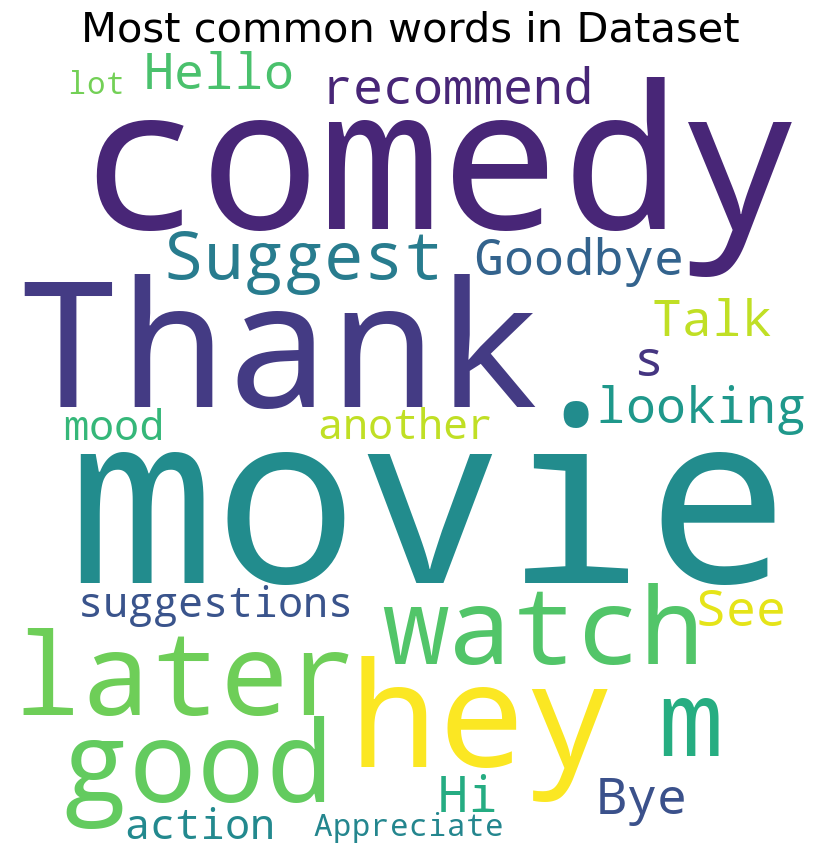

In [73]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all patterns into one long string
all_patterns = ' '.join([' '.join(pattern) for pattern, _ in xy])

# Generate word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(all_patterns)

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Most common words in Dataset', fontsize=30)
plt.show()


# Building Model module

In [58]:
import torch
import torch.nn as nn

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.l2 = nn.Linear(hidden_size, hidden_size) 
        self.l3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        return out

# Training the model

21 patterns
5 tags: ['comedy', 'goodbye', 'greeting', 'recommendation', 'thanks']
39 unique stemmed words: ["'m", "'s", 'a', 'action', 'ani', 'anoth', 'appreci', 'bye', 'can', 'comedi', 'do', 'for', 'good', 'goodby', 'have', 'hello', 'hey', 'hi', 'i', 'in', 'it', 'later', 'like', 'look', 'lot', 'mood', 'movi', 'other', 'recommend', 'see', 'suggest', 'talk', 'thank', 'the', 'there', 'to', 'watch', 'what', 'you']
39 5
Epoch [100/1000], Loss: 0.3576
Epoch [200/1000], Loss: 0.0664
Epoch [300/1000], Loss: 0.0065
Epoch [400/1000], Loss: 0.0065
Epoch [500/1000], Loss: 0.0017
Epoch [600/1000], Loss: 0.0014
Epoch [700/1000], Loss: 0.0008
Epoch [800/1000], Loss: 0.0004
Epoch [900/1000], Loss: 0.0006
Epoch [1000/1000], Loss: 0.0003
final loss: 0.0003
training complete. file saved to data.pth


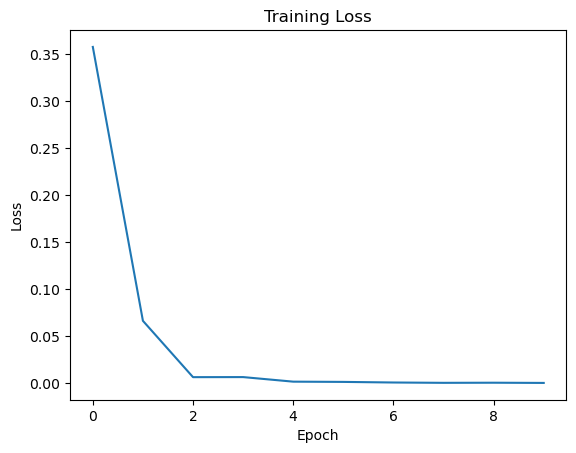

In [68]:
import random
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

with open('dataset/movies.json', 'r') as f:
    movies = json.load(f)

all_words = []
tags = []
xy = []
# loop through each sentence in our intents patterns
for movie in movies['movies']:
    tag = movie['tag']
    # add to tag list
    tags.append(tag)
    for pattern in movie['patterns']:
        # tokenize each word in the sentence
        w = tokenize(pattern)
        # add to our words list
        all_words.extend(w)
        # add to xy pair
        xy.append((w, tag))

all_words = [stem(w) for w in all_words if w not in ignore_words]
# remove duplicates and sort
all_words = sorted(set(all_words))
tags = sorted(set(tags))

print(len(xy), "patterns")
print(len(tags), "tags:", tags)
print(len(all_words), "unique stemmed words:", all_words)

# create training data
X_train = []
y_train = []
for (pattern_sentence, tag) in xy:
    # X: bag of words for each pattern_sentence
    bag = bag_of_words(pattern_sentence, all_words)
    X_train.append(bag)
    # y: PyTorch CrossEntropyLoss needs only class labels, not one-hot
    label = tags.index(tag)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Hyper-parameters 
num_epochs = 1000
batch_size = 8
learning_rate = 0.001
input_size = len(X_train[0])
hidden_size = 12
output_size = len(tags)
print(input_size, output_size)


class ChatDataset(Dataset):

    def __init__(self):
        self.n_samples = len(X_train)
        self.x_data = X_train
        self.y_data = y_train

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

dataset = ChatDataset()
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NeuralNet(input_size, hidden_size, output_size).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_history = []

# Train the model
for epoch in range(num_epochs):
    for (words, labels) in train_loader:
        words = words.to(device)
        labels = labels.to(dtype=torch.long).to(device)
        
        # Forward pass
        outputs = model(words)
        # if y would be one-hot, we must apply
        # labels = torch.max(labels, 1)[1]
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 100 == 0:
        loss_history.append(loss.item())
        print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


print(f'final loss: {loss.item():.4f}')

data = {
"model_state": model.state_dict(),
"input_size": input_size,
"hidden_size": hidden_size,
"output_size": output_size,
"all_words": all_words,
"tags": tags
}

FILE = "data.pth"
torch.save(data, FILE)

print(f'training complete. file saved to {FILE}')
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

# Chatbot input and repond

In [55]:
import random
import json
import torch
import tkinter as tk

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load intents from JSON file
with open('dataset/movies.json', 'r') as json_data:
    movies = json.load(json_data)

# Load data from PyTorch model
FILE = "data.pth"
data = torch.load(FILE)

# Extract variables from data
input_size = data["input_size"]
hidden_size = data["hidden_size"]
output_size = data["output_size"]
all_words = data['all_words']
tags = data['tags']
model_state = data["model_state"]

# Load PyTorch model and set to evaluation mode
model = NeuralNet(input_size, hidden_size, output_size).to(device)
model.load_state_dict(model_state)
model.eval()

# Define bot name
bot_name = "Cleverly"

def close_chatbot_window():
    root.destroy()

# Define function to get response from chatbot
def get_response(user_input):
    if user_input == "quit":
        close_chatbot_window()
        return
    sentence = tokenize(user_input)
    X = bag_of_words(sentence, all_words)
    X = X.reshape(1, X.shape[0])
    X = torch.from_numpy(X).to(device)

    output = model(X)
    _, predicted = torch.max(output, dim=1)

    tag = tags[predicted.item()]

    probs = torch.softmax(output, dim=1)
    prob = probs[0][predicted.item()]
    if prob.item() > 0.75:
        for movie in movies['movies']:
            if tag == movie["tag"]:
                response = random.choice(movie['responses'])
    else:
        response = "I do not understand..."
    return response

# Define function to update chat log
def update_chat_log(user_input, response):
    chat_log.config(state=tk.NORMAL)
    chat_log.insert(tk.END, "You: " + user_input + "\n\n")
    chat_log.insert(tk.END, bot_name + ": " + response + "\n\n")
    chat_log.config(state=tk.DISABLED)
    entry_box.delete(0, tk.END)

# Define function to handle user input
def handle_user_input(event):
    user_input = entry_box.get()
    response = get_response(user_input)
    update_chat_log(user_input, response)
    

In [29]:
import tkinter as tk

def create_window():
    # Create tkinter window
    root = tk.Tk()
    root.title("Chatbot")
    return root

def create_chat_log(root):
    # Create chat log area
    chat_log = tk.Text(root, width=50, height=20, state=tk.DISABLED)
    chat_log.grid(row=0, column=0, padx=10, pady=10)
    return chat_log

def create_entry_box(root):
    # Create entry box for user input
    entry_box = tk.Entry(root, width=50)
    entry_box.grid(row=1, column=0, padx=10, pady=10)
    entry_box.bind("<Return>", handle_user_input)
    return entry_box

def create_send_button(root):
    # Create button for user input
    send_button = tk.Button(root, text="Send", command=lambda: handle_user_input(None))
    send_button.grid(row=1, column=1, padx=10, pady=10)
    return send_button

if __name__ == '__main__':
    # Start tkinter window
    root = create_window()
    chat_log = create_chat_log(root)
    entry_box = create_entry_box(root)
    send_button = create_send_button(root)
    root.mainloop()


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\Hari\anaconda3\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\Users\Hari\AppData\Local\Temp\ipykernel_18224\338902810.py", line 72, in handle_user_input
    update_chat_log(user_input, response)
  File "C:\Users\Hari\AppData\Local\Temp\ipykernel_18224\338902810.py", line 62, in update_chat_log
    chat_log.config(state=tk.NORMAL)
  File "C:\Users\Hari\anaconda3\lib\tkinter\__init__.py", line 1646, in configure
    return self._configure('configure', cnf, kw)
  File "C:\Users\Hari\anaconda3\lib\tkinter\__init__.py", line 1636, in _configure
    self.tk.call(_flatten((self._w, cmd)) + self._options(cnf))
_tkinter.TclError: invalid command name ".!text"
